In [1]:
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

sns.set(style="darkgrid")

BASE_PATH = '../'
ROWS_PATH = f'{BASE_PATH}/rows/{datetime.datetime.utcnow().date().isoformat()}_rows.json'
DATASET_PATH = f'{BASE_PATH}/datasets/{datetime.datetime.utcnow().date().isoformat()}'

MAX_ANSWERS = 4
FIG_SIZE = (10, 5)

rows = json.load(open(ROWS_PATH, 'r'))
rows_df = pd.DataFrame(rows)
question_rows = []
all_annotations = []

for row in rows:
    for question in row['questions']:
        question_row = row.copy()
        annotations = [annotation for annotation in question['annotations'] if
                       not annotation['skipped'] and not annotation['archived']]
        question_row['question'] = question['question']
        question_row['id'] = question['id']

        for index, annotation in enumerate(annotations):
            annotation_row = {
                **annotation,
                'selected': len(annotation['answerLines']),
                'context': row['context'],
                'answerCount': len(row['context'].split('\n')) - 1
            }
            all_annotations.append(annotation_row)
            
            question_row[f'answers{index}'] = annotation['answerLines']
            question_row[f'noAnswer{index}'] = annotation['noAnswer']
            question_row[f'user{index}'] = annotation['user']

        question_rows.append(question_row)

questions_df = pd.DataFrame(question_rows,
                            columns=['id', 'question', 'answers0', 'answers1', 'noAnswer0', 'noAnswer1', 'user0', 'user1', 'context', 'city',
                                     'language'])
annotations_df = pd.DataFrame(all_annotations)
print(len(all_annotations))

# Agreement for all answers
selected_answers = annotations_df.selected.sum()
total_answers = annotations_df.answerCount.sum()
selected_percentage = selected_answers / total_answers
p_selected_agreement = pow(selected_percentage, 2)

# Agreement for max 4 answers
selected_answers_filtered = annotations_df[annotations_df.selected <= MAX_ANSWERS].selected.sum()
total_answers_filtered = annotations_df[annotations_df.selected <= MAX_ANSWERS].answerCount.sum()
selected_percentage_filtered = selected_answers_filtered / total_answers_filtered
p_selected_agreement_filtered = pow(selected_percentage_filtered, 2)

print('Selected agreement/percentage all:', p_selected_agreement, selected_percentage)
print('Selected agreement/percentage (max 4 answers):', p_selected_agreement_filtered, selected_percentage_filtered)

3657
Selected agreement/percentage all: 0.034883823435895786 0.18677211632333074
Selected agreement/percentage (max 4 answers): 0.0031257358200360444 0.055908280424602975


58


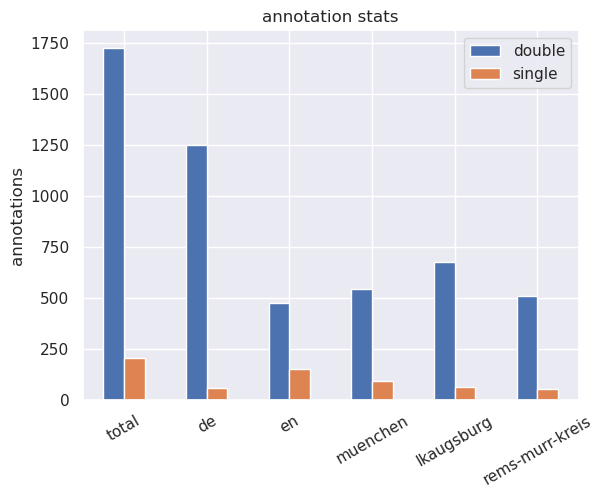

In [2]:
# Annotations stats
def plot_grouped(axis, df, title, y_label, x_ticks, y_ticks=None, x_label=''):
    df.plot.bar(ax=axis, rot=30)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_xticklabels(x_ticks)
    if y_ticks is not None:
        axis.set_yticks(y_ticks)


def plot_annotation_stats(dfs, x_ticks):
    _, axis = plt.subplots()
    annotation_stats_df = pd.DataFrame([[df.answers1.count(), df.answers0.count() - df.answers1.count()] for df in dfs],
                                       columns=['double', 'single'])
    plot_grouped(axis, annotation_stats_df, 'annotation stats', 'annotations', x_ticks)
    
print(questions_df[questions_df['language'] == 'de'].answers0.count() - questions_df[questions_df['language'] == 'de'].answers1.count())

plot_annotation_stats(
    [questions_df, questions_df[questions_df['language'] == 'de'], questions_df[questions_df['language'] == 'en'],
     questions_df[questions_df['city'] == 'muenchen'], questions_df[questions_df['city'] == 'lkaugsburg'],
     questions_df[questions_df['city'] == 'rems-murr-kreis']],
    ['total', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr-kreis'])

Mean document length (chars): 1648.37
Median document length (chars): 1371.0
Mean document length (sentences): 26.8
Median document length (sentences): 22.0


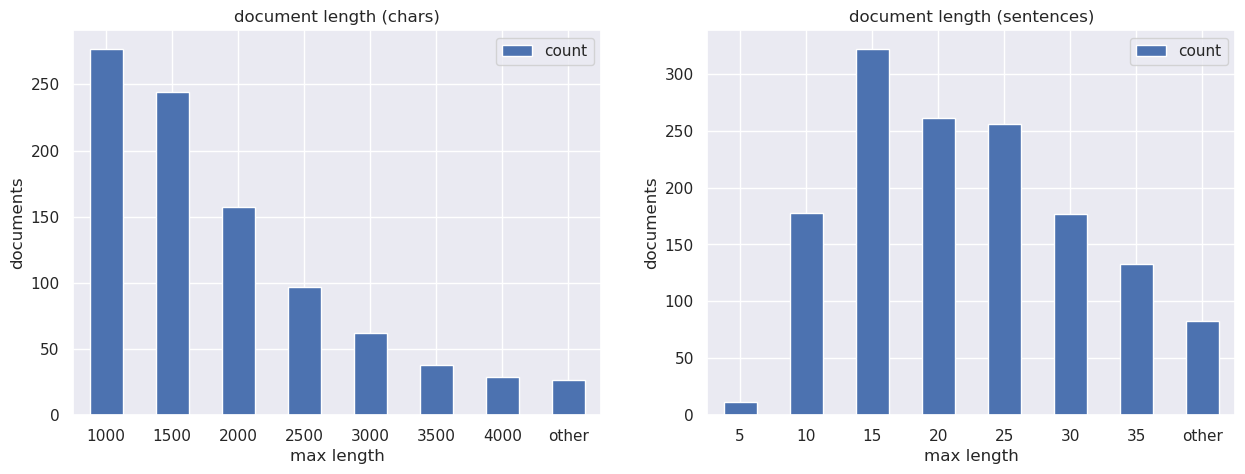

In [3]:
# Document length stats
documents_df = pd.DataFrame(rows)


def plot_counts(axis, column, title, x_label, y_label, digits=0, x_label_rot=0):
    value_count_df = column.value_counts().reset_index()
    value_count_df.columns = ['value', 'count']
    value_count_df = value_count_df.sort_values('value')

    value_count_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(value) if digits == 0 else round(value, ndigits = digits)}' for value in value_count_df['value']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Mean {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {round(column.median(), 2)}')
    
    
def get_bins(column, bins):
    bins_df = pd.cut(column, bins=bins, include_lowest=True).value_counts().reset_index()
    bins_df.columns = ['bin', 'count']
    bins_df['sort'] = bins_df.bin.map(lambda x: x.left)
    bins_df = bins_df.sort_values('sort')
    return bins_df


def plot_count_bins(axis, column, bins, title, x_label, y_label, digits=0, x_label_rot=0, other=True):
    bins_df = get_bins(column, bins)

    bins_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(bin.right) if digits == 0 else round(bin.right, ndigits = digits)}' if bin.right != bins[-1] or not other else 'other' for bin in bins_df['bin']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Mean {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {round(column.median(), 2)}')


group_by_context_length = rows_df.context.str.len().value_counts().reset_index()
group_by_context_length.columns = ['document_length', 'document']

tmp = rows_df.copy()
group_by_answer_count = rows_df.copy()
group_by_answer_count['document_length'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
group_by_answer_count = group_by_answer_count.reset_index()

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
plot_count_bins(ax0, group_by_context_length.document_length,
                numpy.array([0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000]), 'document length (chars)',
                'max length', 'documents')
plot_count_bins(ax1, group_by_answer_count.document_length, numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]),
                'document length (sentences)', 'max length', 'documents')

In [4]:
# Prepare questions with two annotations
def prepare_jaccard(df):
    df['intersection'] = df.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
    df['answers'] = df.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
    df['union'] = df.apply(lambda x: list(set(x.answers0).union(set(x.answers1))), axis=1)
    df['jaccard_pure'] = df.apply(lambda x: len(x.intersection) / len(x.union) if len(x.union) > 0 else 1, axis=1)
    df['jaccard'] = df.apply(lambda x: (x.jaccard_pure - p_selected_agreement) / (1 - p_selected_agreement), axis=1)
    df['jaccard_cc_filtered'] = df.apply(lambda x: (x.jaccard_pure - p_selected_agreement_filtered) / (1 - p_selected_agreement_filtered), axis=1)
    df['diff0'] = df.apply(lambda x: list(set(x.answers0).difference(x.answers1)), axis=1)
    df['diff1'] = df.apply(lambda x: list(set(x.answers1).difference(x.answers0)), axis=1)
    return df
    
double_annotations_df = prepare_jaccard(questions_df[~questions_df.answers0.isnull() & ~questions_df.answers1.isnull()].copy())
filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() <= MAX_ANSWERS) & (double_annotations_df.answers1.str.len() <= MAX_ANSWERS)]
inverse_filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() > MAX_ANSWERS) | (double_annotations_df.answers1.str.len() > MAX_ANSWERS)]

In [5]:
# Plotting helpers
def print_row(values, width=10):
    print(' | '.join([f'{it:^{width}}' for it in values]))


def print_absolute_percentage_row(values, divisor, width=10):
    print_row(values[:1] + [f'{value} ({int(value / divisor * 100)}%)' for value in values[1:]], width)

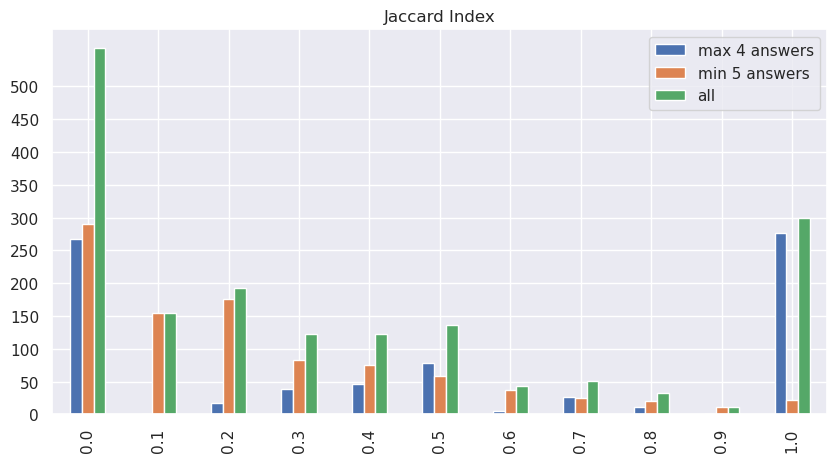

In [6]:
# Plot intersection over union / Jaccard-Index
jaccard_bins = numpy.arange(-0.1, 1.01, 0.1)
# _, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# plot_count_bins(ax0, filtered_double_annotations_df.jaccard, jaccard_bins, f'jaccard index (max {MAX_ANSWERS} answers)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)
# plot_count_bins(ax1, inverse_filtered_double_annotations_df.jaccard, jaccard_bins, f'jaccard index (min {MAX_ANSWERS + 1} answers)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)
# plot_count_bins(ax2, double_annotations_df.jaccard, jaccard_bins, 'jaccard index (all)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)

_, ax = plt.subplots(figsize=(10,5))
answer_dfs = [filtered_double_annotations_df, inverse_filtered_double_annotations_df, double_annotations_df]
jaccard_answer_df = pd.DataFrame([get_bins(df.jaccard, jaccard_bins).reset_index()['count'] for df in answer_dfs]).transpose()
jaccard_answer_df.plot(ax=ax, kind='bar', stacked=False, title='Jaccard Index')
ax.legend([f'max {MAX_ANSWERS} answers', f'min {MAX_ANSWERS + 1} answers', 'all'])
ax.set_xticklabels([round(bin, 1) for bin in jaccard_bins[1:]])
ax.set_yticks(numpy.arange(0, 550, 50))
print()

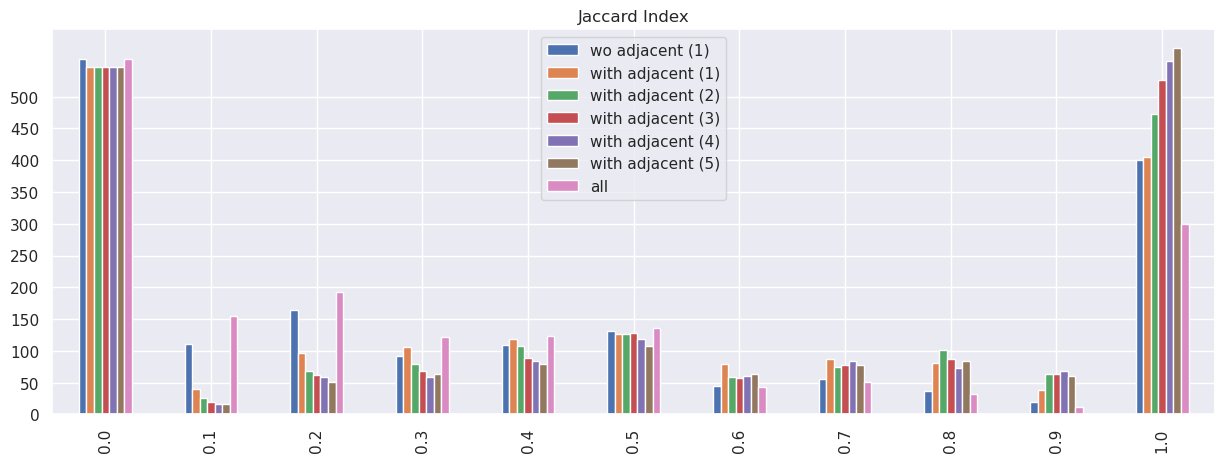

In [7]:
# Remove or add adjacent
def prepare_adjacent_df(df, transfer):
    df = df.copy()
    tmp = df.copy()
    df['answers0'] = tmp.apply(lambda row: transfer(row.answers0, row.answers1), axis=1)
    df['answers1'] = tmp.apply(lambda row: transfer(row.answers1, row.answers0), axis=1)
    return prepare_jaccard(df)

adjacent = lambda line, answers, others: line not in others and ((line - 1 in answers and line - 1 in others) or (line + 1 in answers and line + 1 in others))

# Without context, adjacent answers are removed
remove_directly_adjacent = lambda answers0, answers1: [line for line in answers0 if not adjacent(line, answers0, answers1)]
remove_adjacent = lambda answers0, answers1: [line for line in answers0 if not adjacent(line, answers0, answers1)]
wo_adjacent_1_df = prepare_adjacent_df(double_annotations_df.copy(), remove_directly_adjacent)
wo_adjacent_2_df = prepare_adjacent_df(wo_adjacent_1_df, remove_directly_adjacent)

# With context, adjacent answers are added
add_adjacent = lambda answers0, answers1: list(set(set(answers0).union([line for line in answers1 if adjacent(line, answers1, answers0)])))
w_adjacent_1_df = prepare_adjacent_df(double_annotations_df, add_adjacent)
w_adjacent_2_df = prepare_adjacent_df(w_adjacent_1_df, add_adjacent)
w_adjacent_3_df = prepare_adjacent_df(w_adjacent_2_df, add_adjacent)
w_adjacent_4_df = prepare_adjacent_df(w_adjacent_3_df, add_adjacent)
w_adjacent_5_df = prepare_adjacent_df(w_adjacent_4_df, add_adjacent)

_, ax = plt.subplots(figsize=(15,5))
adjacent_dfs = [wo_adjacent_1_df, w_adjacent_1_df, w_adjacent_2_df, w_adjacent_3_df, w_adjacent_4_df, w_adjacent_5_df, double_annotations_df]
jaccard_adjacent_df = pd.DataFrame([get_bins(df.jaccard, jaccard_bins).reset_index()['count'] for df in adjacent_dfs]).transpose()
jaccard_adjacent_df.plot(ax=ax, kind='bar', stacked=False, title='Jaccard Index')
ax.legend(['wo adjacent (1)', 'with adjacent (1)', 'with adjacent (2)', 'with adjacent (3)', 'with adjacent (4)', 'with adjacent (5)', 'all'])
ax.set_xticklabels([round(bin, 1) for bin in jaccard_bins[1:]])
ax.set_yticks(numpy.arange(0, 550, 50))
print()

In [8]:
# Dataset
DATASET_COLUMNS = ['id', 'question', 'answers', 'context', 'city', 'language', 'jaccard']
JACCARD_THRESHOlD = 0.3
jaccard_df = w_adjacent_1_df
jaccard_agreement_df = jaccard_df[jaccard_df.jaccard >= JACCARD_THRESHOlD]
print(f'Count: {len(jaccard_agreement_df)}({int(len(jaccard_agreement_df) / len(jaccard_df) * 100)})%')

print(f'Mean jaccard: {round(jaccard_agreement_df.jaccard.mean(), 2)}')
print(f'Median jaccard: {round(jaccard_agreement_df.jaccard.median(), 2)}')


def write_dataset(df, suffix=''):
    df = pd.DataFrame(df, columns=DATASET_COLUMNS)
    df_file = open(f'{DATASET_PATH}_dataset{suffix}.json', 'w')
    df_file.write(df.to_json(orient='records'))
    df_file = open(f'{DATASET_PATH}_dataset{suffix}.jsonl', 'w')
    df_file.write(df.to_json(lines=True, orient='records'))
    return df
    

dataset_df = write_dataset(jaccard_agreement_df)
dataset_de_df = write_dataset(jaccard_agreement_df[jaccard_agreement_df['language'] == 'de'], '_de')
dataset_en_df = write_dataset(jaccard_agreement_df[jaccard_agreement_df['language'] == 'en'], '_en') 

dataset_df

Count: 937(54)%
Mean jaccard: 0.75
Median jaccard: 0.76


,id,question,answers,context,city,language,jaccard
0,1,Was ist das Selbsthilfe-Zentrum München?,[2],Selbsthilfezentrum\nSelbsthilfezentrum\nDas Se...,muenchen,de,0.309237
1,2,Was versteht man unter Selbsthilfe?,"[5, 6, 7]",Selbsthilfezentrum\nSelbsthilfezentrum\nDas Se...,muenchen,de,0.481928
4,6,Wo kann man Tickets für die Aufführungen der M...,"[18, 19, 20]",Münchner Kammerspiele\nMünchner Kammerspiele\n...,muenchen,de,1.000000
5,4,Wie heißt das Theater der Stadt München?,"[1, 2]",Münchner Kammerspiele\nMünchner Kammerspiele\n...,muenchen,de,1.000000
8,9,Welche Art von Zertifikat wird für eine Nieder...,"[32, 33, 27, 28, 29, 31]",Brauche ich ein Zertifikat?\nBrauche ich ein Z...,muenchen,de,1.000000
...,...,...,...,...,...,...,...
4860,4856,What kind of group activities does Intercultur...,"[1, 2, 3, 4, 5, 6]",Projekt-Laden International Haidhausen\nProjek...,muenchen,en,0.407917
4863,4860,How can I ensure my child's safety in school?,[],Protecting children and adolescents\nProtectin...,muenchen,en,1.000000
4893,4890,How can I contact a private tutor for language...,"[1, 2, 3]",Private tutoring - General information\nPrivat...,muenchen,en,0.585542
4896,4892,Which public schools offer German language cla...,[],Grundschule (primary school)\nGrundschule\nReg...,muenchen,en,1.000000


In [9]:
# Many answers
many_answers_df = dataset_df[(jaccard_agreement_df.answers.str.len() > MAX_ANSWERS)]
many_answers_df

,id,question,answers,context,city,language,jaccard
8,9,Welche Art von Zertifikat wird für eine Nieder...,"[32, 33, 27, 28, 29, 31]",Brauche ich ein Zertifikat?\nBrauche ich ein Z...,muenchen,de,1.000000
14,80,Welche Angaben sind in der Gehaltsabrechnung o...,"[4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]",Gehaltsabrechnung\nGehaltsabrechnung\nWenn Sie...,muenchen,de,0.920297
40,30,Was versteht man unter irregulärer Beschäftigung?,"[2, 3, 4, 5, 6]",Irreguläre und illegale Beschäftigung\nIrregul...,muenchen,de,0.611446
43,33,Welche Geburtskliniken gibt es?,"[2, 7, 13, 25, 30]",Geburtskliniken\nGeburtskliniken\nFrauenklinik...,muenchen,de,0.481928
62,52,"Was ist notwendig, um eine (duale) betrieblich...","[1, 2, 4, 5, 6, 7, 8, 9]",Mittelschule\nMittelschule\nDie Mittelschule g...,muenchen,de,0.516466
...,...,...,...,...,...,...,...
4779,4774,Who can I contact for help with housing-relate...,"[1, 2, 3, 4, 5, 12, 13]",Help if you are in danger of losing your home\...,muenchen,en,0.521779
4804,4803,Who can help me if I face issues at work?,"[20, 21, 22, 27, 28, 29]",Fair Integration Advice Centre\nFair integrati...,muenchen,en,0.407917
4827,4821,How can I report bullying in school?,"[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17]",JIZ - Counselling for school stress and/or bul...,muenchen,en,0.563729
4860,4856,What kind of group activities does Intercultur...,"[1, 2, 3, 4, 5, 6]",Projekt-Laden International Haidhausen\nProjek...,muenchen,en,0.407917


Mean Jaccard Index by User: 0.31
Median Jaccard Index by User: 0.32


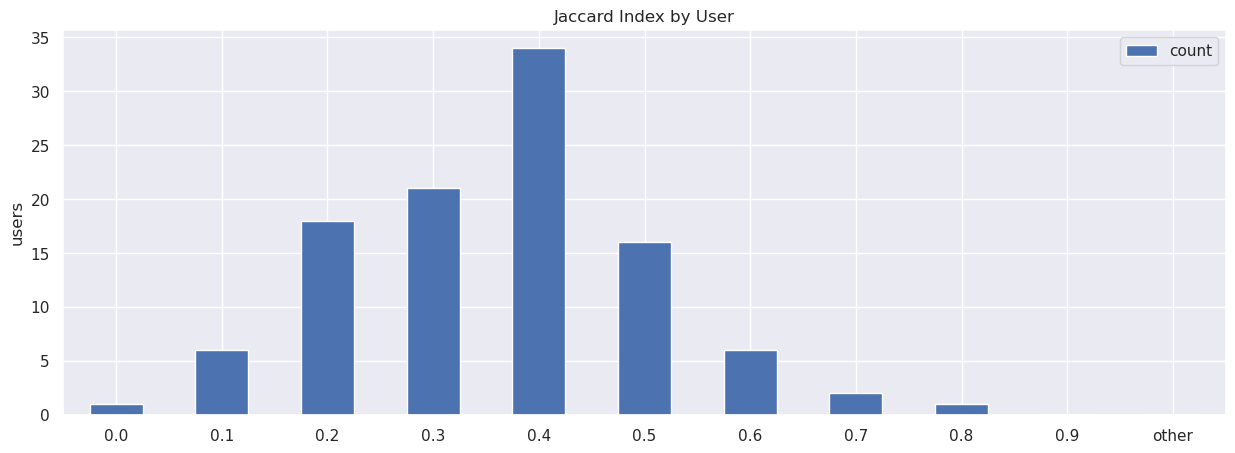

In [10]:
# Agreement by user
tmp = double_annotations_df
columns = list(tmp.columns)
a, b = columns.index('user0'), columns.index('user1')
columns[b], columns[a] = columns[a], columns[b]
tmp = tmp[columns]

agreement_by_user_df = pd.concat([double_annotations_df, tmp]).groupby(['user0']).filter(lambda group: len(group) > 5).groupby(['user0']).jaccard
mean_agreement_by_user_df = pd.DataFrame(agreement_by_user_df.mean())

_, ax = plt.subplots(figsize=(15,5))
plot_count_bins(ax, mean_agreement_by_user_df.jaccard, jaccard_bins, 'Jaccard Index by User', '', 'users', digits=1)

In [11]:
# Agreement by city and language
by_city_language_dfs = [
    double_annotations_df, 
    double_annotations_df[double_annotations_df['language'] == 'de'], 
    double_annotations_df[double_annotations_df['language'] == 'en'],
    double_annotations_df[double_annotations_df['city'] == 'muenchen'],
    double_annotations_df[double_annotations_df['city'] == 'lkaugsburg'],
    double_annotations_df[double_annotations_df['city'] == 'rems-murr-kreis']
]

rows = ['all', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr']
agreement_by_city_language = [[df.jaccard.mean(), df.jaccard.median()] for df in by_city_language_dfs]
print_row(['', 'mean', 'median'])
for index, row in enumerate(agreement_by_city_language):
    print_row([rows[index], round(row[0], 2), round(row[1], 2)])

           |    mean    |   median  
   all     |    0.31    |    0.17   
    de     |    0.32    |    0.17   
    en     |    0.29    |    0.17   
 muenchen  |    0.35    |    0.22   
lkaugsburg |    0.3     |    0.14   
rems-murr  |    0.3     |    0.14   


 answers   | agreement  | one-sided  |  overlap   | no agreement
   < 2     | 264 (53%)  |  56 (11%)  |   9 (1%)   | 161 (32%) 
   < 3     | 272 (43%)  | 108 (17%)  |  33 (5%)   | 216 (34%) 
   < 4     | 277 (36%)  | 161 (20%)  |  62 (8%)   | 268 (34%) 
   < 5     | 283 (31%)  | 196 (21%)  | 104 (11%)  | 320 (35%) 
   < 7     | 290 (26%)  | 271 (24%)  | 161 (14%)  | 392 (35%) 
   < 10    | 293 (22%)  | 334 (25%)  | 247 (18%)  | 456 (34%) 
   all     | 296 (17%)  | 512 (29%)  | 371 (21%)  | 546 (31%) 


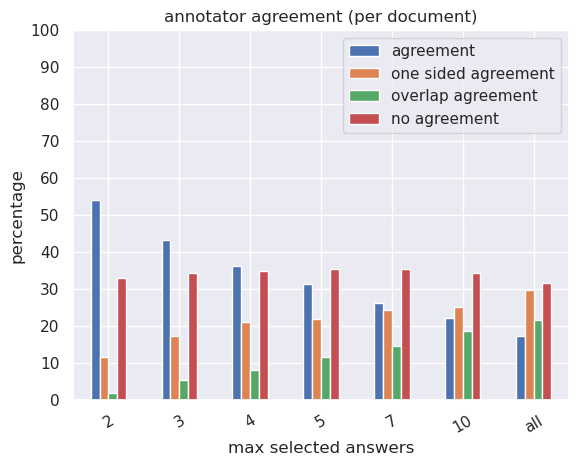

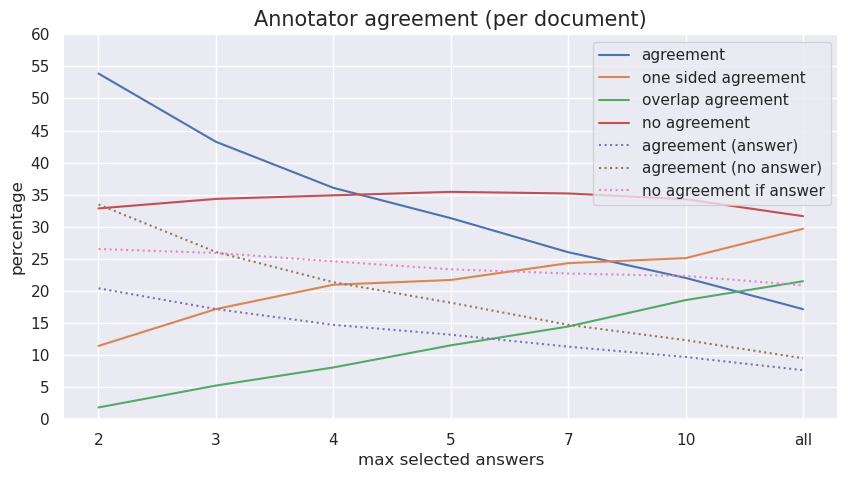

In [12]:
max_answers_thresholds = [2, 3, 4, 5, 7, 10]
agreement_options = ['answers', 'agreement', 'one-sided', 'overlap', 'no agreement']
columns = ['agreement', 'one sided agreement', 'overlap agreement', 'no agreement', 'agreement (answer)',
           'agreement (no answer)', 'no agreement if answer']


def get_annotator_agreement(df, name):
    total_count = len(df)
    raw_agreement = len(df[(df.diff0.str.len() == 0) & (df.diff1.str.len() == 0)])
    raw_agreement_one_sided = len(
        df[((df.diff0.str.len() == 0) != (df.diff1.str.len() == 0)) & (df.intersection.str.len() > 0)])
    raw_agreement_overlap = len(
        df[(df.diff0.str.len() > 0) & (df.diff1.str.len() > 0) & (df.intersection.str.len() > 0)])
    raw_no_agreement = len(
        df[((df.answers0.str.len() > 0) | (df.answers1.str.len() > 0)) & (df.intersection.str.len() == 0)])
    raw_agreement_no_answer = len(df[(df.answers0.str.len() == 0) & (df.answers1.str.len() == 0)])
    raw_agreement_answer = raw_agreement - raw_agreement_no_answer
    raw_no_agreement_answer = len(df[(df.answers0.str.len() == 0) != (df.answers1.str.len() == 0)])

    print_absolute_percentage_row(
        [name, raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement], total_count)
    raw = [raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement, raw_agreement_answer,
           raw_agreement_no_answer, raw_no_agreement_answer]

    return [it / total_count * 100 for it in raw]


def get_double_annotations_max_answers(df, max_answers):
    return df[(df.answers0.str.len() <= max_answers) & (df.answers1.str.len() <= max_answers)]


def get_max_answers_agreement(df):
    agreements = []
    print_row(agreement_options)
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement(get_double_annotations_max_answers(df, max_answers),
                                                  f'< {max_answers}{"" if len(str(max_answers)) == 2 else " "}'))
    agreements.append(get_annotator_agreement(df, 'all '))

    return pd.DataFrame(agreements)


x_ticks = max_answers_thresholds + ['all']
y_ticks = numpy.arange(0, 110, 10)
max_answers_agreement_df = get_max_answers_agreement(double_annotations_df)
max_answers_agreement_df.columns = columns
_, ax = plt.subplots()
plot_grouped(ax, max_answers_agreement_df.copy().iloc[:, :4], title='annotator agreement (per document)',
             x_label='max selected answers', y_label='percentage', x_ticks=x_ticks, y_ticks=y_ticks)

_, ax = plt.subplots(figsize=FIG_SIZE)
ax.set_title('Annotator agreement (per document)', fontsize=15)
ax.set_xlabel('max selected answers')
ax.set_ylabel('percentage')

for index in range(len(max_answers_agreement_df.columns)):
    max_answers_agreement_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 4 else ':')

ax.legend(columns)
ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
ax.set_xticklabels(x_ticks)
ax.set_yticks(numpy.arange(0, 65, 5))
ax.set_ylim(0)
plt.show()

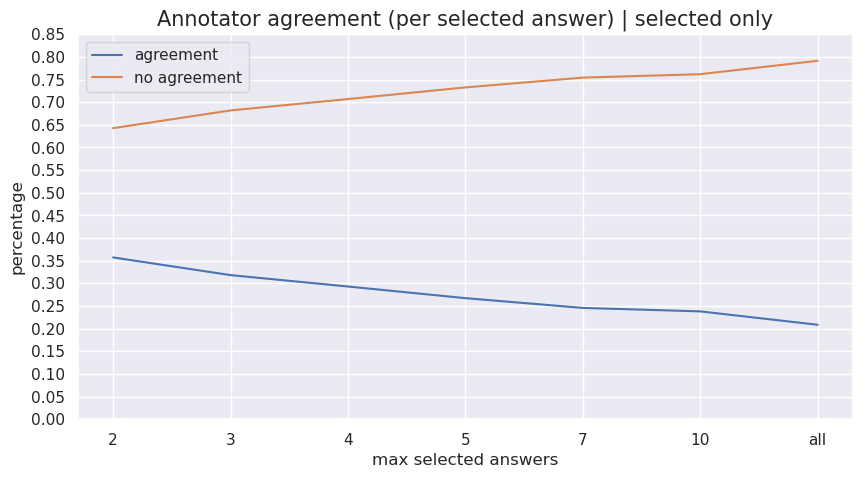

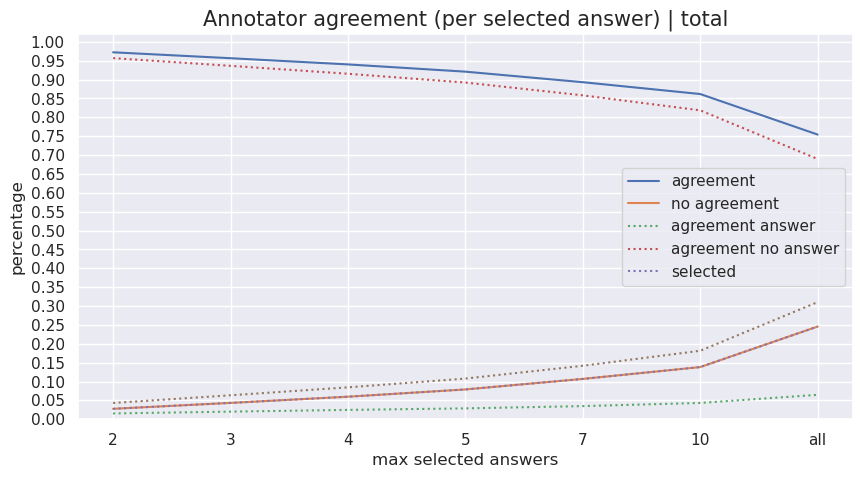

In [13]:
# Plot annotator agreement (per answer)
def get_annotator_agreement_per_answer(df, selected_only):
    raw_agreement_answer = 0
    raw_agreement_no_answer = 0
    raw_no_agreement = 0
    total = 0
    total_selected = 0

    for _, row in df.iterrows():
        possible_answers = len(row.context.split('\n'))
        total += possible_answers - 1
        for i in range(1, possible_answers):
            if i in row.answers0 and i in row.answers1:
                raw_agreement_answer += 1
            elif i not in row.answers0 and i not in row.answers1:
                raw_agreement_no_answer += 1
            else:
                raw_no_agreement += 1

            if i in row.answers0 or i in row.answers1:
                total_selected += 1

    if selected_only:
        agreement_answer = raw_agreement_answer / total_selected
        no_agreement = raw_no_agreement / total_selected
        return [agreement_answer, no_agreement]

    agreement = (raw_agreement_answer + raw_agreement_no_answer) / total
    no_agreement = raw_no_agreement / total
    agreement_answer = raw_agreement_answer / total
    agreement_no_answer = raw_agreement_no_answer / total
    return [agreement, no_agreement, agreement_answer, agreement_no_answer, no_agreement, total_selected / total]


def get_max_answers_agreement_per_answer(df, selected_only):
    agreements = []
    for max_answers in max_answers_thresholds:
        agreements.append(
            get_annotator_agreement_per_answer(get_double_annotations_max_answers(df, max_answers), selected_only))
    agreements.append(get_annotator_agreement_per_answer(df, selected_only))

    return pd.DataFrame(agreements)


selected_only_params = [True, False]
for selected_only in selected_only_params:
    max_answers_agreement_per_answer_df = get_max_answers_agreement_per_answer(double_annotations_df, selected_only)

    x_labels = [f'{max_answers}' for max_answers in max_answers_thresholds]
    x_labels.append('all')

    _, ax = plt.subplots(figsize=FIG_SIZE)
    ax.set_xlabel('max selected answers')
    ax.set_ylabel('percentage')

    for index in range(len(max_answers_agreement_per_answer_df.columns)):
        max_answers_agreement_per_answer_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 2 else ':')

    if selected_only:
        ax.set_title('Annotator agreement (per selected answer) | selected only', fontsize=15)
        ax.legend(['agreement', 'no agreement'])
        ax.set_yticks(numpy.arange(0, 0.90, 0.05))
    else:
        ax.set_title('Annotator agreement (per selected answer) | total', fontsize=15)
        ax.legend(['agreement', 'no agreement', 'agreement answer', 'agreement no answer', 'selected'])
        ax.set_yticks(numpy.arange(0, 1.05, 0.05))
    ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0)
    plt.show()

Mean selected answers: 5.18
Median selected answers: 3.0


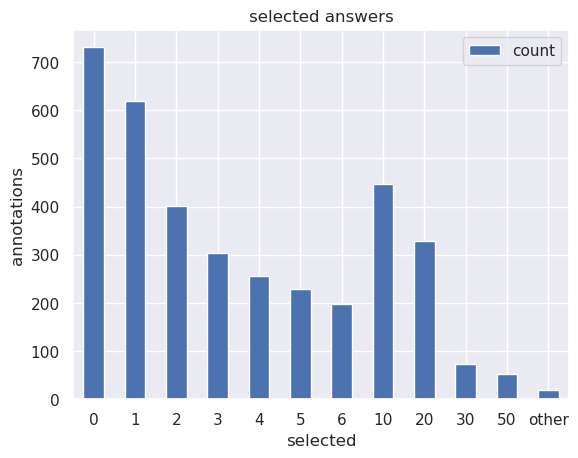

In [14]:
# Plot selection count
_, axis = plt.subplots()
plot_count_bins(axis, annotations_df.selected, [-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000], 'selected answers',
                'selected', 'annotations', digits=0)

Total annotators: 238
Total annotations: 3657
Mean annotations per annotator: 15.37
Median annotations per annotator: 6.0


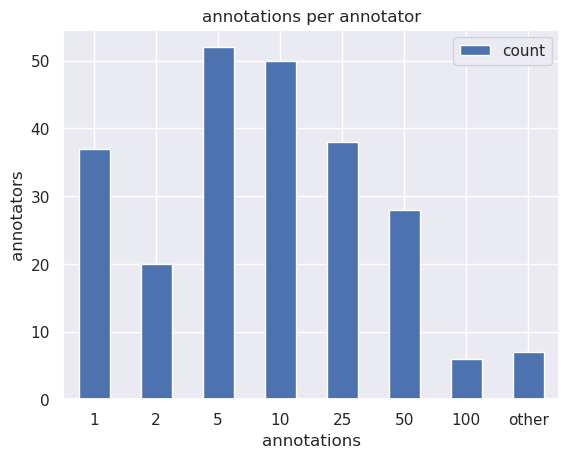

In [15]:
# Plot user contributions
group_by_user = annotations_df.user.value_counts().reset_index()
group_by_user.columns = ['user', 'annotations']
print('Total annotators:', len(group_by_user))
print('Total annotations:', len(annotations_df))

_, axis = plt.subplots()
plot_count_bins(axis, group_by_user.annotations, [0, 1, 2, 5, 10, 25, 50, 100, 1000], 'annotations per annotator',
                'annotations', 'annotators', digits=0)